# Simple Label Transfer

A simple custom way to transfer labels from scATAC clusters to scRNA that helps build intuition.

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)
library(Matrix)
library(DESeq2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    

## Load Data

In [2]:
# saved Seurat session
rna = readRDS("./sessions/20200913_n27632.rds")

In [4]:
# cluster-wise gene scores from ATAC
atac = read.table("./gs.tmp.tsv")
dim(atac)
# these are old clusters
head(atac)

[1] 51767    18

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OR4F5-202,155.2258,198.4009,58.82954,65.15362,53.25156,43.84668,78.14633,174.2233,65.33650,273.0679,124.0222,118.56728,146.6989,87.95880,126.5211,348.2336,122.35538,0.000
OR4F5-201,122.8217,169.6438,50.67583,56.34300,45.24529,37.90634,66.17510,146.7820,51.40294,233.2767,104.9046,97.63954,114.8779,71.52421,105.1064,252.1129,95.95421,0.000
OR4F16-201,139.0672,136.2449,148.12213,147.49211,143.36709,152.95532,139.10939,127.5388,140.93997,119.7214,154.1643,138.71816,138.7084,146.35139,143.0202,143.3955,136.85575,0.000
SAMD11-202,12392.1813,8360.4198,15204.58338,17677.52931,14177.27449,13182.53800,15358.85384,11749.5000,15846.39428,8611.6149,13626.5890,15714.32265,14067.3110,13962.79711,11813.7550,12123.8897,13961.17598,2342.731
SAMD11-213,12358.8317,8338.0903,15161.90345,17624.59899,14140.78305,13148.34988,15315.74046,11716.3121,15804.83727,8588.5260,13586.7123,15670.47471,14030.3812,13928.97628,11781.5720,12094.0481,13925.89892,2342.487
NOC2L-201,21243.2182,16625.2915,22711.58820,26986.96013,26186.86116,25133.27131,26404.49797,22253.8807,24677.08146,20129.9863,21422.9755,25095.06831,23599.0031,23101.04404,21632.1258,24679.4794,22319.82208,0.000


In [3]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster,colour,description,new_cluster
<int>,<fct>,<fct>,<int>
1,#F4D5CD,Intermediate,12
2,#78A824,Pre-iPSC,15
3,#F01D35,Fibroblast-like,5
4,#E85F6D,Fibroblast-like,3
5,#B03743,Fibroblast,1
6,#7C2730,Fibroblast,2
7,#CF175A,Fibroblast-like,4
8,#CCCCCC,Doublets,17
9,#F7A6C2,Keratinocyte-like,6


## Integration

### RNA clustered

In [7]:
# get raw counts matrix
rna_subset_raw = Matrix::t(rna@assays$RNA@data)
dim(rna_subset_raw)

[1] 59369 27632

In [8]:
clusters = as.numeric(rna@meta.data$RNA_snn_res.0.5)
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(rna_subset_raw)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(rna_subset_raw)))

In [9]:
cts = as.matrix(agg_matrix %*% rna_subset_raw)
colnames(cts) = rownames(rna)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14
AL627309.1,8.0213160,9.2138837,2.315508,2.7053517,1.453870,7.800057,0.000000,10.777766,2.7680987,2.0775698,3.2365640,0.9640926,0.7108032,0.7267291
AL627309.5,28.5799971,24.4674477,14.084754,24.8828941,13.269927,18.917467,11.051620,37.879949,16.2086590,23.8239650,33.1218283,6.3282055,13.9856513,4.6928365
AP006222.2,0.2946217,0.3216007,0.000000,0.4678908,0.000000,0.000000,0.000000,0.000000,0.4165649,0.4733274,0.4712369,0.0000000,0.0000000,0.0000000
LINC01409,96.8202184,159.7951813,61.187476,75.0472009,78.213297,104.914721,49.404361,109.881024,64.3174078,82.6649312,69.7599561,38.5451935,34.8078300,18.6457634
FAM87B,3.4694415,8.3628128,10.884119,8.5464469,7.954121,1.979404,3.288781,1.538119,2.6959917,4.3897733,0.7530208,0.8196389,1.9167667,2.4641029
LINC01128,270.3353478,401.8008839,472.221504,277.3190306,453.949345,258.486521,262.291198,206.508718,254.5791435,176.2332566,180.0301555,144.1858659,117.5518151,155.9071009


[1] 27632    14

In [10]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

### scRNA Cluster-wise Integration

In [41]:
var_genes = VariableFeatures(rna)[VariableFeatures(rna) %in% rownames(norm_cts)] # rownames(norm_cts) 
ref_genes = paste(var_genes, "201", sep="-")
atac_ref = atac[ref_genes[ref_genes %in% rownames(atac)], ]
rna_ref = norm_cts[var_genes[ref_genes %in% rownames(atac)], ]
dim(rna_ref)
dim(atac_ref)

[1] 1486   14

[1] 1486   18

In [42]:
# remove doublet and iPSC
atac_ref = atac_ref[, !colnames(atac_ref) %in% c("cluster_8", "cluster_18")]

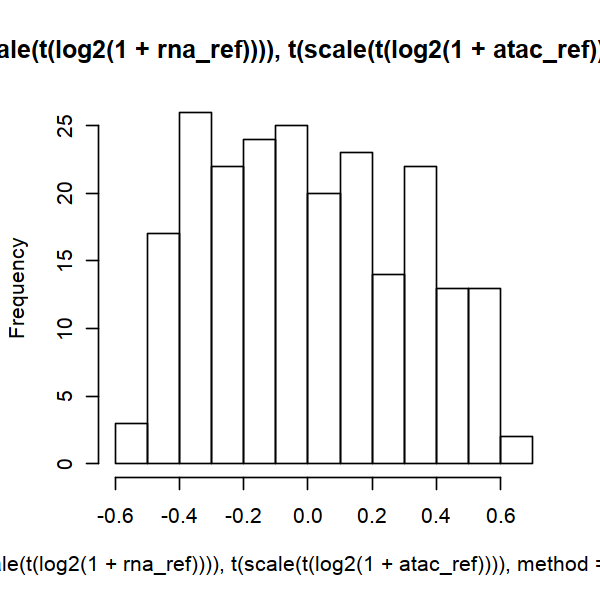

In [43]:
options(repr.plot.width = 5, repr.plot.height = 5)

hist(cor(t(scale(t(log2(1+rna_ref)))), t(scale(t(log2(1+atac_ref)))), method='spearman'))

In [44]:
df = cor(t(scale(t(log2(1+rna_ref)))),t(scale(t(log2(1+atac_ref)))), method = 'spearman')
map_df = data.frame(rna=rownames(df), 
                    atac=colnames(df)[apply(df,1,which.max)], 
                    cor=apply(df,1,max))
head(map_df)

,rna,atac,cor
,<fct>,<fct>,<dbl>
cluster_1,cluster_1,cluster_5,0.5842090
cluster_2,cluster_2,cluster_1,0.6130749
cluster_3,cluster_3,cluster_7,0.5514463
cluster_4,cluster_4,cluster_4,0.5583218
cluster_5,cluster_5,cluster_16,0.4473019
cluster_6,cluster_6,cluster_15,0.5340245


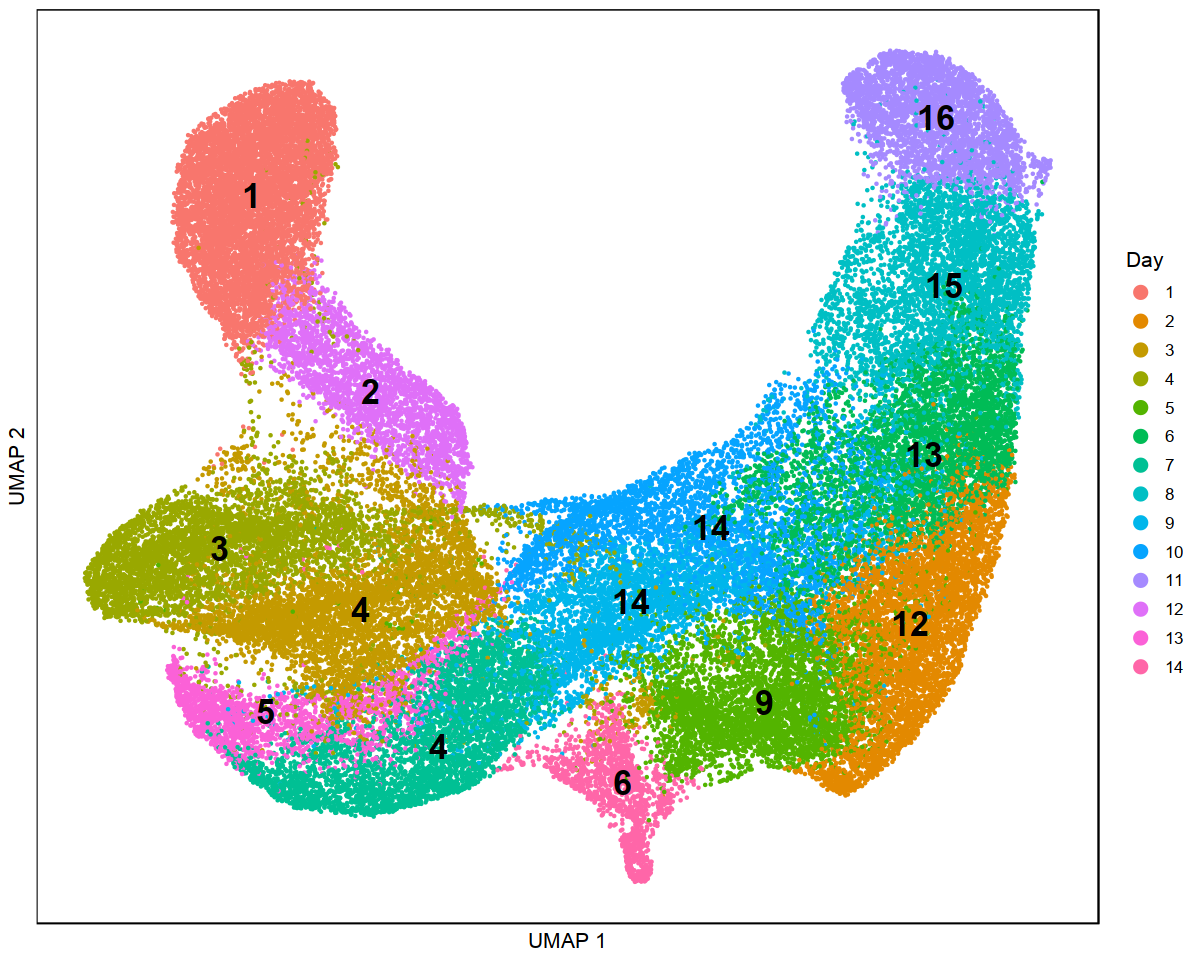

In [50]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot_df <- data.frame(umap1=data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
                 umap2=data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
                 cluster=factor(clusters))
plot_df = plot_df[sample(dim(plot_df)[1]), ]

label_df = data.frame(aggregate(plot_df[,c("umap1","umap2")], 
                            list(plot_df$cluster), median))
label_df$label = lapply(strsplit(as.character(map_df[label_df$Group.1, "atac"]), "_"), "[[", 2)
# replace with new cluster
label_df$label = cluster_config[as.numeric(label_df$label), "new_cluster"]

ggplot(plot_df) +
geom_point(aes(x=umap1, y=umap2, color=cluster), stroke=0, size=1) +
geom_text(data=label_df,
         aes(x=umap1, y=umap2, 
             label=label), fontface = "bold", size=7) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

### Single-cell label transfer

In [24]:
rna_scaled = rna@assays$RNA@data

In [25]:
rownames(rna_scaled) = rownames(rna)

In [26]:
rna_ref = rna_scaled[var_genes[ref_genes %in% rownames(atac)], ]
dim(rna_ref)

[1]  1486 59369

In [27]:
rna_ref_logznorm = t(scale(t(log2(1+rna_ref))))

In [28]:
assigned = colnames(atac_ref)[apply(cor(rna_ref_logznorm,t(scale(t(log2(1+atac_ref)))), method = 'pearson'),1,which.max)]
assigned = as.numeric(lapply(strsplit(assigned, "_"), "[[", 2))

# transfer to new labels
assigned = cluster_config[assigned, "new_cluster"]

In [29]:
table(assigned)

assigned
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
6650 4051 7032 7343 2678 2036 2009  554 3697  306 1416 6450 3746 3444 3871 4086 

In [30]:
head(plot_df)

,umap1,umap2,cluster
,<dbl>,<dbl>,<fct>
24458,8.166741,0.02468124,6
39234,6.035738,-6.13716266,2
16681,5.452924,-2.94625399,2
20809,-7.746647,-1.75949213,4
53134,8.511990,6.24036982,8
3021,-6.524852,5.42776540,1


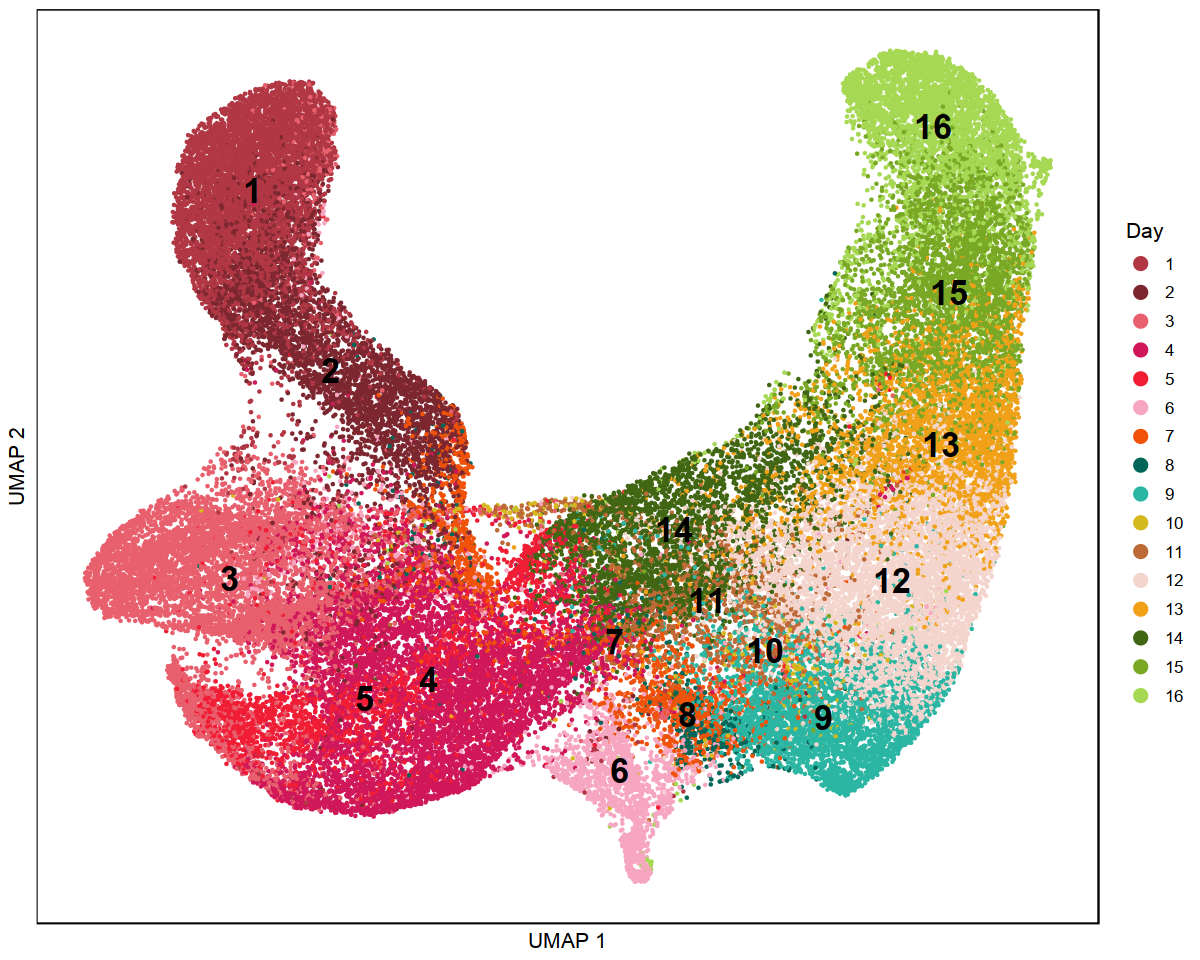

In [33]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot_df <- data.frame(umap1=data.frame(Embeddings(rna, reduction='umap'))$UMAP_1,
                 umap2=data.frame(Embeddings(rna, reduction='umap'))$UMAP_2,
                 cluster=factor(assigned),
                     day=rna@meta.data$sample)
# plot_df = plot_df[plot_df$day=="D2", ]
plot_df = plot_df[sample(dim(plot_df)[1]), ]

label_df = data.frame(aggregate(plot_df[,c("umap1","umap2")], 
                            list(plot_df$cluster), median))

cluster_config_subset = cluster_config[cluster_config$new_cluster %in% as.numeric(unique(assigned)),]
cluster_config_subset = cluster_config_subset[order(cluster_config_subset$new_cluster), ]

ggplot(plot_df) +
geom_point(aes(x=umap1, y=umap2, color=cluster), stroke=0, size=1) +
geom_text(data=label_df,
         aes(x=umap1, y=umap2, 
             label=Group.1), fontface = "bold", size=7) +
scale_color_manual(values=as.character(cluster_config_subset$colour)) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

---

In [34]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] DESeq2_1.26.0               SummarizedExperiment_1.16.1
 [3] DelayedArray_0.12.3         BiocParallel_1.20.1        
 [5] matrixStats_0.56.0          Biobase_2.46.0             
 [7] GenomicRanges_1.38.0        GenomeInfoDb_1.22.1        
 [9] IRanges_2.20.2            